# Reproducibility notebook for the paper "COMPLETE"

## Install and import dependences

In [2]:
using Pkg
Pkg.add(url="https://github.com/vittorioerba/FreeEnergyMultimodeQED.jl.git")

   Updating git-repo `https://github.com/vittorioerba/FreeEnergyMultimodeQED.jl.git`


  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [7]:
using FreeEnergyMultimodeQED, JLD, DelimitedFiles

┌ Info: Precompiling FreeEnergyMultimodeQED [5d5b1dbe-d68d-4a76-a227-7e1c4d9731fe]
└ @ Base loading.jl:1278


## Directories

**RAW DATA DIRECTORY:** the raw data we simulated can be found [here](https://unimi2013-my.sharepoint.com/:f:/g/personal/vittorio_erba_unimi_it/EgDqAdK9WBRFuuI3qoUuJawBhMPM0Ac71lA-scwLNtMTPg?e=6SjuTR), in the subdirectory ```raw```. If the link is broken, please contact the authors. Pay attention that the full raw data weights **~16Gb**.

**PROCESSED DATA DIRECTORY:** the processed data can be found [here](https://unimi2013-my.sharepoint.com/:f:/g/personal/vittorio_erba_unimi_it/EgDqAdK9WBRFuuI3qoUuJawBhMPM0Ac71lA-scwLNtMTPg?e=6SjuTR), in the subdirectory ```processed```. If the link is broken, please contact the authors. Pay attention that the full processed data weights **~4Gb**.

**PLOTS DIRECTORY:** the plots can be found [here](https://unimi2013-my.sharepoint.com/:f:/g/personal/vittorio_erba_unimi_it/EgDqAdK9WBRFuuI3qoUuJawBhMPM0Ac71lA-scwLNtMTPg?e=6SjuTR), in the subdirectory ```plots```. If the link is broken, please contact the authors. 

In [9]:
Dir = "/run/media/vittorio/Extreme SSD/backup/Onedrive/myPHDfolder/scienza/datasets/2010-FreeEnergyMultimodeQED/"
rawDir = Dir*"raw/"
processedDir = Dir*"processed/"
plotDir = Dir*"plots/"

"/run/media/vittorio/Extreme SSD/backup/Onedrive/myPHDfolder/scienza/datasets/2010-FreeEnergyMultimodeQED/plots/"

## Reproduce raw data

The raw data of the local minima can be reproduced by using the function ```simulateMinima```

In [3]:
? simulateMinima

search: simulateMinima



```
simulateMinima(p::Int,q::Int,iter::Int,file::String)
```

Optimizes the model at parameters (p,q) looking for a local minimum using the :gradient optimizer, and appends the result to `file`. It iterates the search `iter` times starting from random initial conditions. 


**REMARK:** we performed our simulations using the [LCM cluster](https://lcm.mi.infn.it/). Running the simulations without some form of parallelization may result in very long execution times. Consider using [Threads](https://docs.julialang.org/en/v1/manual/multi-threading/), or even better a computational cluster, to execute many small bathces of minimization in parallel.

## Reproduce processed data

The processed ```.jld``` files are produced by applying ```analyzeGS, analyzeMinima, checkMinimaFound``` to the raw data, preprocessed using ```parseRawData``` and ```preprocessRawDataframe```.

More concretely, suppose that ```file.csv``` contains the raw data for some parameters ```(q,p)```. 
Then, the analyzed data can be produced using
```
    preprocessed = parseRawData("file.csv") |> preprocessRawDataframe
    analyzeGS(preprocessed, "output_GS.jld")
    analyzeMinima(preprocessed, "output_Minima.jld")
    checkMinimaFound(preprocessed, "output_checkMinima.jld")
```

In the next cell you find the code that processes all raw data.

**REMARK:** uncomment the needed lines. Pay attention that some analysis may take some time to be completed.

In [ ]:
parameters = FreeEnergyMultimodeQED.whichQP(rawDir) |> u->sort(u,by=first)

for (q,p) in parameters
    println(p,"/",q)
    preprocessed = parseRawData(string(rawDir,"q",q,"_p",p,".csv")) |> preprocessRawDataframe
    #analyzeGS(preprocessed, string(processedDir,"q",q,"_p",p,"_GS.jld"))
    #analyzeMinima(preprocessed, string(processedDir,"q",q,"_p",p,"_MINIMA.jld"))
    #checkMinimaFound(preprocessed, string(processedDir,"q",q,"_p",p,"_CHECK_MINIMA.jld"))
end

## Figures

In this section, you can find the code used to produce the data plots in the paper.
Notice that some sizes may seem off, and many axes are unlabeled.
This is because some plots where postprocessed in Inkscape for graphical reasons, and the sizes and labels where optimized to ease the postprocessing. 
See the paper for details on what each plot represents.

In [14]:
using Plots, LinearAlgebra, LsqFit, Statistics, LaTeXStrings, Measurements, StatsPlots, Plots.PlotMeasures, Clustering

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1278
┌ Info: Precompiling LaTeXStrings [b964fa9f-0449-5b57-a5c2-d3ea65f4040f]
└ @ Base loading.jl:1278
┌ Info: Precompiling Measurements [eff96d63-e80a-5855-80a2-b1b0885c5ab7]
└ @ Base loading.jl:1278
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1278


### Figure 1: Dendrograms

In [40]:
inputFIG1dendro(p,q) = string(processedDir,"q",q,"_p",p,"_MINIMA.jld")
outputFIG1dendro(p,q) = string(plotDir,"FIG1_dendro_q",q,"_p",p,".pdf")

outputFIG1dendro (generic function with 1 method)

In [65]:
function plot_dendrogram(p,q)
    
    states = load(inputFIG1dendro(p,q))["states"]
    
    ll = length(states)
    dists = zeros(ll,ll)
    for i in 1:ll
        s1 = states[i]
        dists[i,i] = 0
        for j in i+1:ll
            s2 = states[j]
            d = norm(s1-s2)
            dists[i,j] = d
            dists[j,i] = d
        end
    end
    
    cluster = hclust(dists,linkage=:average,branchorder=:optimal)
    
    p1 = plot(
        cluster,
        xticks = [],
        yticks = (0:0.25:10,[]),
        showaxis = false,
        gridalpha = 0.5,
        size = (650, 300),
    )
    
    savefig(p1, outputFIG1dendro(p,q))
    return p1
end

plot_dendrogram (generic function with 1 method)

In [40]:
inputFIG1dendro(p,q) = string(processedDir,"q",q,"_p",p,"_MINIMA.jld")
outputFIG1dendro(p,q) = string(plotDir,"FIG1_dendro_q",q,"_p",p,".pdf")

outputFIG1dendro (generic function with 1 method)

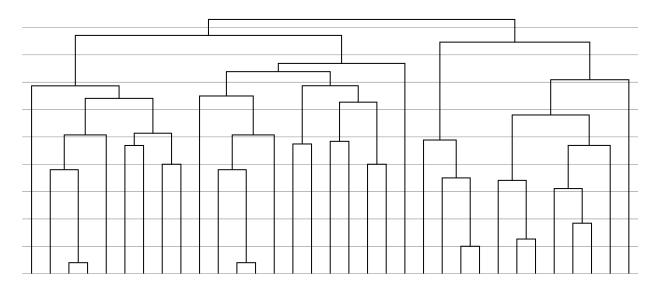

In [66]:
plot_dendrogram(13,21)

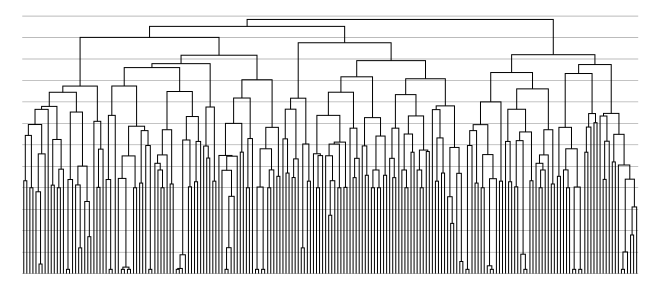

In [67]:
plot_dendrogram(21,34)

### Figure 2: Number of metastable states

In [67]:
inputFIG2number(p,q) = string(processedDir,"q",q,"_p",p,"_MINIMA.jld")
outputFIG2number = string(plotDir,"FIG2_number.pdf");

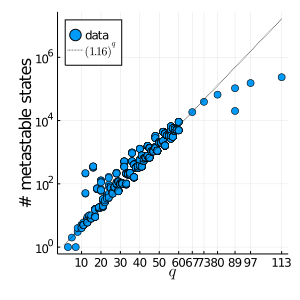

In [72]:
parameters = FreeEnergyMultimodeQED.whichQP(rawDir) |> u->sort(u,by=first)

let xs = parameters .|> first, 
    ys = parameters .|> u -> ( load(inputFIG2number(u[2],u[1]))["states"] |> length ),
    qMaxMetastable = 60
    
    plotMetaNvsQ = plot(
        size = (300,300),
        xlabel = L"q",
        ylabel = "# metastable states",
        legend = :topleft,
        yscale = :log10,
        xticks = vcat(10:10:60,67,73,80,89,97,113) |> u->(u,u)
    )

    plotMetaNvsQ = plot!(
        xs,
        ys, 
        seriestype=:scatter,
        label = "data"
    )


    @. expGrowth(x,p) = p[1]^x
    fitMetaNvsQ = 
    curve_fit(
        expGrowth,
        xs[xs .<= qMaxMetastable],
        ys[xs .<= qMaxMetastable],
        [2.]
    )
    fitMetaNvsQBase = round(coef(fitMetaNvsQ)[1],digits=2)

    # function that predicts the GS energy with error
    function predictNmetaStates(q)
        params = coef(fitMetaNvsQ)
        errors = stderror(fitMetaNvsQ)
        expGrowth(q,[ params[1] ± errors[1] ])
    end

    plotMetaNvsQ = plot!(
        1:max(xs...), 
        1:max(xs...) .|> u->predictNmetaStates(u).val,
        ribbon = 1:max(xs...) .|> u->predictNmetaStates(u).err,
        fillalpha = 0.5,
        fillcolor = :lightblue,
        linecolor = :black,
        linestyle = :dot,
        label = L"(%$fitMetaNvsQBase)^q",
        #title = string("Max q used for fit: ",qMaxMetastable)
    )

    savefig(plotMetaNvsQ,outputFIG2number)
    plotMetaNvsQ |> display
end

### Figure 2 + SM: Check on minima

In [6]:
inputFIG2check(p,q) = string(processedDir,"q",q,"_p",p,"_CHECK_MINIMA.jld")
outputFIG2check(q) = string(plotDir,"FIG2_check_q",q,".pdf")

outputFIG2check (generic function with 1 method)

In [16]:
function plot_check(q)
    plt = plot(
        size = (200,100),
        legend=:none,
    )
    ps = filter( u -> u[1]==q , FreeEnergyMultimodeQED.whichQP(rawDir) |> u->sort(u,by=first) )  .|> u->u[2]
    
    for p in ps

        hist = load(inputFIG2check(p,q))["saturationCurve"]
        println(hist)
        
        if length(hist[:,1]) < 200
            xs = hist[:,1]
        else
            xs = vcat(1:10:100,100:200:length(  hist[:,1] )) |> collect
        end

        plt = plot!(hist[xs,1],hist[xs,2])
    end

    savefig(plt,outputFIG2check(q))
    plt
end

plot_check (generic function with 1 method)

In [17]:
parameters = filter( u->u[1]>=10 ,  FreeEnergyMultimodeQED.whichQP(rawDir) |> u->sort(u,by=first) )

for q in parameters[1:end] .|> first
    plot_check(q)
end

### Figure 2: Linear size of attraction basins

In [23]:
inputFIG3linearBasin(p,q) = string(processedDir,"q",q,"_p",p,"_MINIMA.jld")
outputFIG3linearBasin = string(plotDir,"FIG3_linearBasin.pdf")

"/run/media/vittorio/Extreme SSD/backup/Onedrive/myPHDfolder/scienza/datasets/2010-FreeEnergyConfocal/plots/FIG3_linearBasin.pdf"

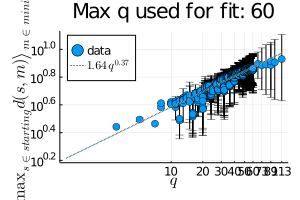

In [24]:
parameters = FreeEnergyMultimodeQED.whichQP(rawDir) |> u->sort(u,by=first)

let xs = parameters .|> first, 
    ds = parameters .|> u -> ( load(inputFIG3linearBasin(u[2],u[1]))["basinDistances"] .|> v->max(v...) ),
    qMaxMetastable = 60
    
    ys = mean.(ds)
    zs = var.(ds)  
    
    plotMetaBasinLinvsQ = plot(
        size = (300,200),
        xlabel = L"q",
        ylabel = latexstring("\\left\\langle \\max_{ s \\in {\\rm starting} } d(s,m) \\right\\rangle_{m \\in {\\rm minima}}"),
        legend = :topleft,
        xscale = :log10,
        yscale = :log10,
        xticks = vcat(10:10:60,73,89,113) |> u->(u,u)
    )

    plotMetaBasinLinvsQ = plot!(
        xs,
        ys, 
        yerror = zs,
        seriestype=:scatter,
        label = "data"
    )

    @. polyGrowth(x,p) = p[1] * x^p[2]
    fitMaxBasinLin=
    curve_fit(
        polyGrowth,
        xs[xs .<= qMaxMetastable],
        ys[xs .<= qMaxMetastable],
        [1.,1.]
    )
    fitMaxBasinLinExp = round(coef(fitMaxBasinLin)[2],digits=2)
    fitMaxBasinLinBase = round(coef(fitMaxBasinLin)[1],digits=2)
    
    # function that predicts the GS energy with error
    function predictMaxBasinLinSize(q)
        params = coef(fitMaxBasinLin)
        errors = stderror(fitMaxBasinLin)
        polyGrowth(q,[ params[1] ± errors[1] , params[2] ± errors[2] ])
    end
    
    plotMaxLinearBasin = 
    plot!(
        1:max(xs...),
        1:max(xs...) .|> u->predictMaxBasinLinSize(u).val,
        ribbon = 1:max(xs...) .|> u->predictMaxBasinLinSize(u).err,
        fillalpha = 0.5,
        fillcolor = :lightblue,
        linecolor = :black,
        linestyle = :dot,
        label = L"%$fitMaxBasinLinBase \, q^{%$fitMaxBasinLinExp}",
        title = string("Max q used for fit: ",qMaxMetastable)
    )

    savefig(plotMaxLinearBasin,outputFIG3linearBasin)
    
    plotMaxLinearBasin |> display
end

### Figure 3: Ground state time of computation

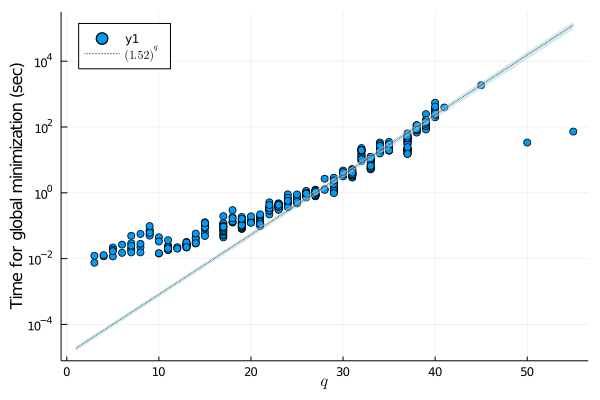

In [76]:
let qMax = 45
    
    data = readdlm(Dir*"GS_parsed.dat")
    xs = data[:,2]
    ys = data[:,3]
    
    timedata = plot(xs,ys,
        linetype=:scatter,
        yscale=:log10,
        legend=:topleft,
        xlabel=L"q",
        ylabel="Time for global minimization (sec)"
    )
    
    @. expGrowth(x,p) = p[2] * p[1]^x
    fitTime = 
    curve_fit(
        expGrowth,
        xs[xs .<= qMax],
        ys[xs .<= qMax],
        [2., 1.]
    )
    fitTimeBase = round(coef(fitTime)[1],digits=2)

    # function that predicts the GS energy with error
    function predictTime(q)
        params = coef(fitTime)
        errors = stderror(fitTime)
        expGrowth(q,[ params[1] ± errors[1], params[2] ± errors[2] ])
    end

    timedata = plot!(
        1:max(xs...), 
        1:max(xs...) .|> u->predictTime(u).val,
        ribbon = 1:max(xs...) .|> u->predictTime(u).err,
        fillalpha = 0.5,
        fillcolor = :lightblue,
        linecolor = :black,
        linestyle = :dot,
        label = L"(%$fitTimeBase)^q",
        #title = string("Max q used for fit: ",qMaxMetastable)
    )
    
    
    savefig(timedata, plotDir*"SM_timeCPLEX.pdf")
    timedata |> display
    
    
end

### Additional: Overlaps

In [68]:
# custom marginal hist

@userplot MyMarginalHist

@recipe function f(h::MyMarginalHist)
    if length(h.args) != 2 || !(typeof(h.args[1]) <: AbstractVector) ||
        !(typeof(h.args[2]) <: AbstractVector)
        error("Marginal Histograms should be given two vectors.  Got: $(typeof(h.args))")
    end
    x, y = h.args

    # set up the subplots
    legend := false
    link := :both
    framestyle := [:none :box :none]
    grid := true
    layout := @layout [tophist           _
                       hist2d{0.9w,0.9h} righthist]


    # main histogram2d
    @series begin
        size := (400,400)
        seriestype := :scatter
        subplot := 2
        xlims := [-1.05,1.05]
        x, y
    end

    # these are common to both marginal histograms
    # fillcolor := :black
    fillalpha := 0.3
    linealpha := 0.3
    seriestype := :histogram
    
    # upper histogram
    @series begin
        subplot := 1
        x
    end

    # right histogram
    @series begin
        orientation := :h
        subplot := 3
        y
    end
end

In [69]:
inputFIG2overlap(p,q) = string(processedDir,"q",q,"_p",p,"_MINIMA.jld")
outputFIG2overlap(p,q) = string(plotDir,"FIG2_overlap_q",q,"_p",p,".pdf")

outputFIG2overlap (generic function with 1 method)

In [73]:
function plot_overlaps(p,q)
    states = load(inputFIG2overlap(p,q))["states"]
    states = vcat(states, -states)
    energies = states .|> s -> modelFreeEnergy(s,p,q,0)
    GSenergy = min(energies...)
    GSconfigurations = states[energies .== GSenergy]
    overlaps = GSconfigurations .|> s1 -> ( states .|> s2 -> dot(s1,s2)/norm(s1)/norm(s2) )
    
    p1 = mymarginalhist(
        overlaps[1],
        energies.-GSenergy,
        bins=:auto,
    )
    
    p1 |> display
    savefig(p1,outputFIG2overlap(p,q))
end

plot_overlaps (generic function with 2 methods)

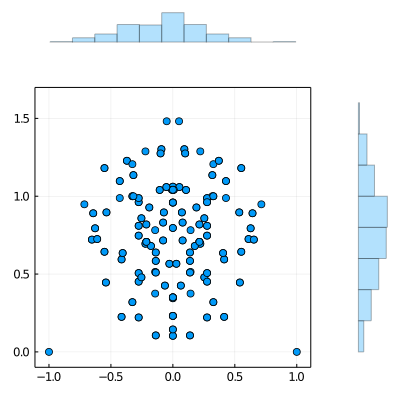

In [74]:
plot_overlaps(12,29)

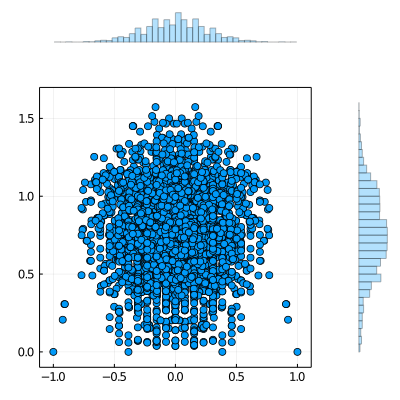

In [75]:
plot_overlaps(1,51)

### Additional: Fit fig SM

In [16]:
inputFIG2check(p,q) = string(processedDir,"q",q,"_p",p,"_CHECK_MINIMA.jld")
outputFIG2checkFIT(p,q) = string(plotDir,"FIG2_check_FIT_q",q,"_p",p,".pdf")

outputFIG2checkFIT (generic function with 1 method)

In [67]:
function plot_check_fit(p,q)
    plt = plot(
        size = (400,200),
        legend=:bottomright,
        title=string("q = ", q, " | p = ", p),
        xlabel="N run",
        ylabel="N minima"
    )
        
    hist = load(inputFIG2check(p,q))["saturationCurve"]

    if length(hist[:,1]) < 200
        xs = hist[:,1]
    else
        xs = vcat(1:10:100,100:200:length(  hist[:,1] )) |> collect
    end

    plt = plot!(hist[xs,1],hist[xs,2],label="Simulations")
    
    # FIT
    @. model(x, p) = p[1]*(1-exp(-x*p[2]))
    p0 = [hist[end,2],1]
    fit = curve_fit(model, hist[:,1], hist[:,2], p0)
    ys_fit = hist[:,1] .|> x -> model(x, coef(fit))

    plt = plot!(hist[:,1],ys_fit,color = :black,
        label=string("Asymptote: ", round(coef(fit)[1], digits=1))
    )

    savefig(plt,outputFIG2checkFIT(p,q))
    plt
end

plot_check_fit (generic function with 1 method)

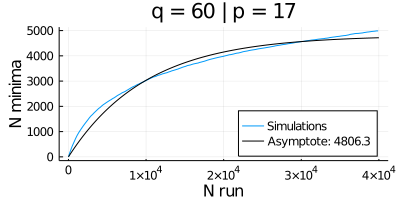

In [71]:
plot_check_fit(17,60)